https://archive.ics.uci.edu/ml/datasets/student+performance

In [1]:
# A - with all variables from Table 1 except G3 (the
# output);
# B - similar to A but without G2 (the second period
# grade); and
# C - similar to B but without G1 (the first period

# 1. Binary classification – pass if G310, else fail;
# 2. 5-Level classification – based on the Erasmus1
# grade conversion system (Table 2);
# 3. Regression – the G3 value (numeric output between
# 0 and 20).


# Table 2: The five-level classification system
# I II III IV V
# Country (excellent/very good) (good) (satisfactory) (sufficient) (fail)
# Portugal/France 16-20 14-15 12-13 10-11 0-9
# Ireland A B C D F

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.utils import shuffle
from scipy.stats import ranksums
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import warnings
from math import log2

def KFoldCV(model, data, n_fold=10):
#     num = len(data)
    diff = int(len(data)/n_fold)
    results = np.zeros((n_fold, 4))
    for i in range(n_fold):
        begin = diff*i
        end = diff*(i+1)
#         if i == n_fold-1:
#             end = -1
        test = data[begin:end]
        train = deepcopy(data)
        train = np.delete(train, range(begin, end),axis=0)
        X_train, y_train = train[:,:-1], train[:,-1]
        X_test, y = test[:,:-1], test[:,-1]
        predictY = model.fit(X_train, y_train).predict(X_test)
        mae = np.mean(abs((y-predictY)))
        stdErr = np.std(((y-predictY)))
        error=sum((y-predictY)**2)
        RMSE=np.sqrt(error/len(y))
        MAC = np.dot(y,predictY)**2/(np.dot(y, y)*np.dot(predictY, predictY))
#         print(mae, stdErr, RMSE, MAC)
        results[i,:] = [mae, stdErr, RMSE, MAC]
    return results

warnings.filterwarnings('ignore')

# data = pd.read_csv('./student-mat.csv', sep=';')
# por = pd.read_csv('./student-por.csv', sep=';')
# combine = pd.merge(math, por, on=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"])
# data = data.values
# data = shuffle(data)

In [4]:
data=pd.read_csv('./exams.csv')
data['math_score']=data['math score']
data.drop(columns=['math score'],inplace=True)
data.drop(columns=['reading score'],inplace=True)
data.drop(columns=['writing score'],inplace=True)

cats = ['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course']
oe = OrdinalEncoder()
for c in cats:
    oe.fit(data[c].values.reshape(-1,1))
    data[c] = np.asarray(oe.transform(data[c].values.reshape(-1,1)),dtype=int)
#     np.asarray(data['gender'],dtype=int)
data = data.values
data = shuffle(data)

In [5]:
# data.shape (395, 33)
# np.savetxt('math.txt',data)
data.shape

(1000, 6)

# Complementary CatBoost

In [28]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# F(x) = F'(x) + Error(x)
# F(x) = F'(x) + noise * Error(x)
# F(x) = weighted * F'(x) + noise * Error(x)
# train F'(x)
# train Error(x)

def gridSearch4CatBoost(X,y,n_estimators,max_depth):
#     cbc = CatBoostRegressor(verbose=False,task_type="GPU",devices='0:1')
# #     cbc = RandomForestRegressor()
#     grid = {'max_depth': [3,4,5],'n_estimators':[100,300,500]}
#     gscv = GridSearchCV (estimator = cbc, param_grid = grid, cv = 10)
#     gscv.fit(X,y)
#     return gscv.best_estimator_
    return CatBoostRegressor(verbose=False,task_type="GPU",devices='0:1',n_estimators=n_estimators,max_depth=max_depth).fit(X,y)

def KFoldCV2(data,n_estimators,max_depth, n_fold=10):
#     num = len(data)
    diff = int(len(data)/n_fold)
    results = np.zeros((n_fold, 4))
    for i in range(n_fold):
        begin = diff*i
        end = diff*(i+1)
        if i == n_fold-1:
            end = -1
        test = data[begin:end]
        train = deepcopy(data)
        train = np.delete(train, range(begin, end),axis=0)
        X_train, y_train = train[:,:-1], train[:,-1]
        X_test, y = test[:,:-1], test[:,-1]
#        gridSearch4CatBoost grid search for F'(x) and Error(x)
        model = gridSearch4CatBoost(X_train, y_train,n_estimators,max_depth)
        errorY = y_train - model.predict(X_train)
#         model = gridSearch4CatBoost(np.hstack((X_train,errorY.reshape((len(errorY),1)))), y_train,n_estimators,max_depth)
#         errorYBi = [1 if i > 0 else -1 for i in errorY]
#         modelDir = CatBoostClassifier(verbose=False,task_type="GPU",devices='0:1',n_estimators=n_estimators,max_depth=max_depth).fit(X_train, errorYBi)
#         yDir = modelDir.predict(X_train)
#         print(yDir)
        predictYe = gridSearch4CatBoost(X_train, errorY,n_estimators,max_depth).predict(X_test)
#         predictYe = gridSearch4CatBoost(X_train, errorY,n_estimators,max_depth).predict(np.hstack((X_test,predictYe))
#         predictYdir = modelDir.predict(X_test)
#         predictYp = model.predict(np.hstack((X_test,predictYe.reshape((len(predictYe),1)))))
        predictYp = model.predict(X_test)
        predictY = predictYp + predictYe#*predictYdir
#         predictY = predictY.astype(int)
#         print(predictYe)
#         print(predictYp)
#         print(predictY)
#         print(y)
        mae = np.mean(abs((y-predictY)))
        stdErr = np.std(y-predictY)
        error=sum((y-predictY)**2)
        RMSE=np.sqrt(error/len(y))
        MAC = np.dot(y,predictY)**2/(np.dot(y, y)*np.dot(predictY, predictY))
#         print(mae, stdErr, RMSE, MAC)
        results[i,:] = [mae, stdErr, RMSE, MAC]
    return results

n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [500]
max_depth = [3]
epochs=20
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            result = KFoldCV2(data,i,j)
            cats[epoch,:] = np.mean(result, axis=0)
        print(np.mean(cats, axis=0))

[10.28313001 12.58178048 12.64748641  0.96618514]


In [29]:
cats

array([[10.33683681, 12.61418604, 12.68702128,  0.96598765],
       [10.30611661, 12.60183855, 12.66658037,  0.96596826],
       [10.2596241 , 12.59210571, 12.64140485,  0.96608665],
       [10.22991   , 12.53095897, 12.60274352,  0.96659239],
       [10.25820485, 12.55637855, 12.62804114,  0.96630289],
       [10.25020433, 12.55842569, 12.6044201 ,  0.966364  ],
       [10.24542597, 12.52399484, 12.61793501,  0.96642894],
       [10.25663489, 12.55877569, 12.64032688,  0.96632518],
       [10.2423483 , 12.50053725, 12.58394767,  0.96652428],
       [10.2769226 , 12.52375557, 12.62735493,  0.96631577],
       [10.33037594, 12.60746296, 12.71607984,  0.96612578],
       [10.3051041 , 12.49598675, 12.66456567,  0.96643821],
       [10.25721347, 12.58380297, 12.6218869 ,  0.96628678],
       [10.33380234, 12.63402144, 12.69468005,  0.96586823],
       [10.31050308, 12.61405711, 12.64169679,  0.96605114],
       [10.28396951, 12.61476   , 12.64565803,  0.96611099],
       [10.29561949, 12.

In [15]:
hidden_layer_sizes  = [100, 300, 500]
max_iter = [500, 1000,1500]
hidden_layer_sizes  = [100]
max_iter = [1500]
# epochs=20
mlps = np.zeros((epochs,4))
for i in hidden_layer_sizes:
    for j in max_iter:
        for epoch in range(epochs):
            data = shuffle(data)
            model = MLPRegressor(hidden_layer_sizes=i, max_iter=j)
            result = KFoldCV(model, data)
            mlps[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(mlps, axis=0))
mlps

[10.50035188 12.82000237 12.88493592  0.96492894]


array([[10.48674677, 12.8078695 , 12.87240416,  0.96507965],
       [10.53517642, 12.83205261, 12.91528779,  0.96484173],
       [10.50550186, 12.78842066, 12.88444854,  0.96512614],
       [10.48260742, 12.78890605, 12.8780005 ,  0.96498124],
       [10.47123931, 12.73472935, 12.82594575,  0.96528171],
       [10.47070507, 12.80627762, 12.85139089,  0.96498894],
       [10.50325423, 12.86522618, 12.91052004,  0.96473301],
       [10.53420467, 12.87783045, 12.93766032,  0.96469861],
       [10.50438269, 12.80893905, 12.89600462,  0.96500389],
       [10.51451285, 12.87138102, 12.90724974,  0.96471261],
       [10.5268448 , 12.8221958 , 12.87587816,  0.96482719],
       [10.54986849, 12.84050778, 12.94037312,  0.96483127],
       [10.47476423, 12.7709702 , 12.86547292,  0.965134  ],
       [10.48106027, 12.8264216 , 12.88693323,  0.96483193],
       [10.52897254, 12.90780823, 12.92161945,  0.96448549],
       [10.49807048, 12.82188902, 12.87300827,  0.96498761],
       [10.51400508, 12.

In [16]:
Cs = [10, 100, 1000]
gammas = [0.001, 0.01, 0.1]
Cs = [1000]
gammas = [0.01]
svms = np.zeros((epochs,4))
for i in range(len(Cs)):
    for j in range(len(gammas)):
        lc = len(Cs)
        lg = len(gammas)
        for epoch in range(epochs):
            data = shuffle(data)
            model = SVR(kernel = 'rbf', C = Cs[i], gamma = gammas[j])
            result = KFoldCV(model, data)
            svms[epoch,:] = np.mean(result, axis=0)
        print(np.mean(svms, axis=0))
svms

[10.58700921 12.91784524 12.99657763  0.96442133]


array([[10.57437472, 12.8953004 , 12.98231542,  0.96448172],
       [10.61261776, 12.97907919, 13.02963848,  0.96415158],
       [10.59859422, 12.92461952, 13.00838953,  0.96450851],
       [10.56897548, 12.82646712, 12.96267449,  0.96486945],
       [10.59704072, 12.9379981 , 12.99069344,  0.96433838],
       [10.63603724, 12.95876046, 13.05753988,  0.96428943],
       [10.55067538, 12.88991121, 12.95368201,  0.9645632 ],
       [10.59245468, 12.88907046, 13.00413572,  0.96443792],
       [10.59427915, 12.95789553, 13.01666104,  0.96422114],
       [10.53541485, 12.93160971, 12.9730646 ,  0.96438938],
       [10.5645061 , 12.93380823, 12.99605943,  0.96439393],
       [10.54631055, 12.89700294, 12.96376519,  0.96459302],
       [10.63398602, 12.90690832, 13.02889217,  0.96445196],
       [10.60491849, 12.9686663 , 13.01721786,  0.96423902],
       [10.59708434, 12.93854284, 12.99525839,  0.96428993],
       [10.59823391, 12.94222359, 13.01642311,  0.96427868],
       [10.60769202, 12.

In [17]:
n_estimators  = [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [100]
max_depth = [4]
rfs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = RandomForestRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            rfs[epoch,:] = np.mean(result, axis=0)
        print(np.mean(rfs, axis=0))
rfs

[10.5287168  12.88943416 12.96146096  0.96457344]


array([[10.56357783, 12.88727565, 12.99753526,  0.96463465],
       [10.53297773, 12.89137669, 12.96219978,  0.9646313 ],
       [10.52324232, 12.96168836, 13.00424839,  0.96424371],
       [10.49477024, 12.78760309, 12.91549021,  0.96510856],
       [10.48057071, 12.88381109, 12.9370011 ,  0.9646202 ],
       [10.4883514 , 12.8674062 , 12.94058004,  0.96463169],
       [10.51186583, 12.916243  , 12.93666646,  0.96434479],
       [10.54334732, 12.87422563, 12.95530473,  0.96471365],
       [10.60652864, 12.95832899, 13.02431264,  0.96421873],
       [10.48117518, 12.84014675, 12.89142272,  0.96474119],
       [10.54688498, 12.87702812, 12.95197175,  0.96454124],
       [10.57259057, 12.89499898, 12.9932968 ,  0.96462527],
       [10.56169665, 12.93041388, 13.01116206,  0.96436662],
       [10.5093062 , 12.84503194, 12.94185713,  0.96492102],
       [10.51569235, 12.91958979, 12.96432907,  0.96446239],
       [10.51440637, 12.90038312, 12.95015115,  0.96456386],
       [10.55548129, 12.

In [18]:
n_estimators= [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [100]
max_depth = [3]
xgbs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = XGBRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            xgbs[epoch,:] = np.mean(result, axis=0)
        print(np.mean(xgbs, axis=0))
xgbs

[10.53736862 12.9356543  13.00629692  0.96429965]


array([[10.59453449, 12.97493785, 13.0392183 ,  0.96417082],
       [10.52275826, 12.96471467, 13.02392113,  0.96410156],
       [10.50078196, 12.90976589, 12.9234842 ,  0.96444215],
       [10.55995133, 12.90853524, 13.00903503,  0.96450645],
       [10.49710229, 12.86186487, 12.9386831 ,  0.96463293],
       [10.58856044, 12.96164819, 13.07171611,  0.96413088],
       [10.57241734, 12.96683691, 13.0691375 ,  0.96420584],
       [10.58340266, 13.01337159, 13.05066923,  0.96384601],
       [10.48791776, 12.90167286, 12.96371815,  0.96450736],
       [10.50817938, 12.83895388, 12.97258178,  0.96457466],
       [10.48010977, 12.8971459 , 12.95864208,  0.96454718],
       [10.57944787, 12.98298161, 13.01770227,  0.9640574 ],
       [10.57545399, 13.01333779, 13.06511775,  0.96394314],
       [10.59054166, 12.97664756, 13.02542407,  0.96405854],
       [10.58804293, 12.94936715, 13.03445054,  0.96428529],
       [10.47809878, 12.92456989, 12.99586497,  0.9643792 ],
       [10.4839207 , 12.

In [19]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [300]
max_depth = [3]
# epochs=20
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = CatBoostRegressor(n_estimators=i, max_depth=j,verbose=False)
            result = KFoldCV(model, data)
            cats[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(cats, axis=0))
cats

[10.45099405 12.81351062 12.87977424  0.96495319]


array([[10.43668665, 12.7518325 , 12.84209266,  0.96525321],
       [10.48622276, 12.85962859, 12.91683639,  0.96463912],
       [10.44452485, 12.75252797, 12.85235839,  0.96530756],
       [10.40030812, 12.66324739, 12.79546205,  0.9656369 ],
       [10.44673406, 12.77961754, 12.8589656 ,  0.96515095],
       [10.52031387, 12.86390428, 12.96018662,  0.9646344 ],
       [10.39484448, 12.74367705, 12.81334193,  0.9653066 ],
       [10.3817023 , 12.79552965, 12.83340393,  0.96512806],
       [10.42168628, 12.80462077, 12.87416943,  0.96511627],
       [10.43253794, 12.80198235, 12.88539444,  0.96516333],
       [10.42798356, 12.81734462, 12.87138615,  0.96504814],
       [10.42994194, 12.72157684, 12.79882631,  0.96529172],
       [10.46572014, 12.81540202, 12.87823005,  0.96486769],
       [10.42819439, 12.82923961, 12.8743509 ,  0.96492173],
       [10.48743441, 12.92057298, 12.96505872,  0.9644901 ],
       [10.4590054 , 12.83360445, 12.88636052,  0.96475712],
       [10.50737738, 12.

In [30]:
mlps = np.array([[10.48674677, 12.8078695 , 12.87240416,  0.96507965],
       [10.53517642, 12.83205261, 12.91528779,  0.96484173],
       [10.50550186, 12.78842066, 12.88444854,  0.96512614],
       [10.48260742, 12.78890605, 12.8780005 ,  0.96498124],
       [10.47123931, 12.73472935, 12.82594575,  0.96528171],
       [10.47070507, 12.80627762, 12.85139089,  0.96498894],
       [10.50325423, 12.86522618, 12.91052004,  0.96473301],
       [10.53420467, 12.87783045, 12.93766032,  0.96469861],
       [10.50438269, 12.80893905, 12.89600462,  0.96500389],
       [10.51451285, 12.87138102, 12.90724974,  0.96471261],
       [10.5268448 , 12.8221958 , 12.87587816,  0.96482719],
       [10.54986849, 12.84050778, 12.94037312,  0.96483127],
       [10.47476423, 12.7709702 , 12.86547292,  0.965134  ],
       [10.48106027, 12.8264216 , 12.88693323,  0.96483193],
       [10.52897254, 12.90780823, 12.92161945,  0.96448549],
       [10.49807048, 12.82188902, 12.87300827,  0.96498761],
       [10.51400508, 12.84150621, 12.89245333,  0.96490806],
       [10.47082229, 12.75702868, 12.82607655,  0.96502539],
       [10.49410751, 12.84791165, 12.90544909,  0.96488883],
       [10.46019072, 12.78217572, 12.83254198,  0.96521146]])

svms = np.array([[10.57437472, 12.8953004 , 12.98231542,  0.96448172],
       [10.61261776, 12.97907919, 13.02963848,  0.96415158],
       [10.59859422, 12.92461952, 13.00838953,  0.96450851],
       [10.56897548, 12.82646712, 12.96267449,  0.96486945],
       [10.59704072, 12.9379981 , 12.99069344,  0.96433838],
       [10.63603724, 12.95876046, 13.05753988,  0.96428943],
       [10.55067538, 12.88991121, 12.95368201,  0.9645632 ],
       [10.59245468, 12.88907046, 13.00413572,  0.96443792],
       [10.59427915, 12.95789553, 13.01666104,  0.96422114],
       [10.53541485, 12.93160971, 12.9730646 ,  0.96438938],
       [10.5645061 , 12.93380823, 12.99605943,  0.96439393],
       [10.54631055, 12.89700294, 12.96376519,  0.96459302],
       [10.63398602, 12.90690832, 13.02889217,  0.96445196],
       [10.60491849, 12.9686663 , 13.01721786,  0.96423902],
       [10.59708434, 12.93854284, 12.99525839,  0.96428993],
       [10.59823391, 12.94222359, 13.01642311,  0.96427868],
       [10.60769202, 12.95253494, 13.01176903,  0.96427376],
       [10.57464604, 12.86895167, 12.97755066,  0.96464486],
       [10.52924204, 12.88391929, 12.91884683,  0.96453716],
       [10.62310045, 12.87363501, 13.02697543,  0.96447355]])

rfs = np.array([[10.56357783, 12.88727565, 12.99753526,  0.96463465],
       [10.53297773, 12.89137669, 12.96219978,  0.9646313 ],
       [10.52324232, 12.96168836, 13.00424839,  0.96424371],
       [10.49477024, 12.78760309, 12.91549021,  0.96510856],
       [10.48057071, 12.88381109, 12.9370011 ,  0.9646202 ],
       [10.4883514 , 12.8674062 , 12.94058004,  0.96463169],
       [10.51186583, 12.916243  , 12.93666646,  0.96434479],
       [10.54334732, 12.87422563, 12.95530473,  0.96471365],
       [10.60652864, 12.95832899, 13.02431264,  0.96421873],
       [10.48117518, 12.84014675, 12.89142272,  0.96474119],
       [10.54688498, 12.87702812, 12.95197175,  0.96454124],
       [10.57259057, 12.89499898, 12.9932968 ,  0.96462527],
       [10.56169665, 12.93041388, 13.01116206,  0.96436662],
       [10.5093062 , 12.84503194, 12.94185713,  0.96492102],
       [10.51569235, 12.91958979, 12.96432907,  0.96446239],
       [10.51440637, 12.90038312, 12.95015115,  0.96456386],
       [10.55548129, 12.88080648, 12.97274616,  0.96457834],
       [10.52363536, 12.90432541, 12.94917328,  0.96452265],
       [10.56344746, 12.93302288, 13.00309517,  0.96429194],
       [10.48478753, 12.83497725, 12.92667525,  0.96470702]])

xgbs = np.array([[10.59453449, 12.97493785, 13.0392183 ,  0.96417082],
       [10.52275826, 12.96471467, 13.02392113,  0.96410156],
       [10.50078196, 12.90976589, 12.9234842 ,  0.96444215],
       [10.55995133, 12.90853524, 13.00903503,  0.96450645],
       [10.49710229, 12.86186487, 12.9386831 ,  0.96463293],
       [10.58856044, 12.96164819, 13.07171611,  0.96413088],
       [10.57241734, 12.96683691, 13.0691375 ,  0.96420584],
       [10.58340266, 13.01337159, 13.05066923,  0.96384601],
       [10.48791776, 12.90167286, 12.96371815,  0.96450736],
       [10.50817938, 12.83895388, 12.97258178,  0.96457466],
       [10.48010977, 12.8971459 , 12.95864208,  0.96454718],
       [10.57944787, 12.98298161, 13.01770227,  0.9640574 ],
       [10.57545399, 13.01333779, 13.06511775,  0.96394314],
       [10.59054166, 12.97664756, 13.02542407,  0.96405854],
       [10.58804293, 12.94936715, 13.03445054,  0.96428529],
       [10.47809878, 12.92456989, 12.99586497,  0.9643792 ],
       [10.4839207 , 12.88208511, 12.95941418,  0.96456107],
       [10.5237919 , 12.9190761 , 12.99494575,  0.96438291],
       [10.48352383, 12.86581058, 12.95910195,  0.96471041],
       [10.54883504, 12.99976246, 13.05311036,  0.96394927]])

cats = np.array([[10.43668665, 12.7518325 , 12.84209266,  0.96525321],
       [10.48622276, 12.85962859, 12.91683639,  0.96463912],
       [10.44452485, 12.75252797, 12.85235839,  0.96530756],
       [10.40030812, 12.66324739, 12.79546205,  0.9656369 ],
       [10.44673406, 12.77961754, 12.8589656 ,  0.96515095],
       [10.52031387, 12.86390428, 12.96018662,  0.9646344 ],
       [10.39484448, 12.74367705, 12.81334193,  0.9653066 ],
       [10.3817023 , 12.79552965, 12.83340393,  0.96512806],
       [10.42168628, 12.80462077, 12.87416943,  0.96511627],
       [10.43253794, 12.80198235, 12.88539444,  0.96516333],
       [10.42798356, 12.81734462, 12.87138615,  0.96504814],
       [10.42994194, 12.72157684, 12.79882631,  0.96529172],
       [10.46572014, 12.81540202, 12.87823005,  0.96486769],
       [10.42819439, 12.82923961, 12.8743509 ,  0.96492173],
       [10.48743441, 12.92057298, 12.96505872,  0.9644901 ],
       [10.4590054 , 12.83360445, 12.88636052,  0.96475712],
       [10.50737738, 12.86892805, 12.93545282,  0.96453374],
       [10.47259642, 12.9097735 , 12.93527395,  0.96444229],
       [10.45623928, 12.86376299, 12.90459895,  0.9646674 ],
       [10.51982681, 12.87343928, 12.91373496,  0.96470742]])

ccats = np.array([[10.33683681, 12.61418604, 12.68702128,  0.96598765],
       [10.30611661, 12.60183855, 12.66658037,  0.96596826],
       [10.2596241 , 12.59210571, 12.64140485,  0.96608665],
       [10.22991   , 12.53095897, 12.60274352,  0.96659239],
       [10.25820485, 12.55637855, 12.62804114,  0.96630289],
       [10.25020433, 12.55842569, 12.6044201 ,  0.966364  ],
       [10.24542597, 12.52399484, 12.61793501,  0.96642894],
       [10.25663489, 12.55877569, 12.64032688,  0.96632518],
       [10.2423483 , 12.50053725, 12.58394767,  0.96652428],
       [10.2769226 , 12.52375557, 12.62735493,  0.96631577],
       [10.33037594, 12.60746296, 12.71607984,  0.96612578],
       [10.3051041 , 12.49598675, 12.66456567,  0.96643821],
       [10.25721347, 12.58380297, 12.6218869 ,  0.96628678],
       [10.33380234, 12.63402144, 12.69468005,  0.96586823],
       [10.31050308, 12.61405711, 12.64169679,  0.96605114],
       [10.28396951, 12.61476   , 12.64565803,  0.96611099],
       [10.29561949, 12.62743629, 12.66031417,  0.96601867],
       [10.28086414, 12.61781853, 12.63906315,  0.96607816],
       [10.29356238, 12.62036133, 12.67003498,  0.96601652],
       [10.30935731, 12.65894539, 12.69597291,  0.96581229]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


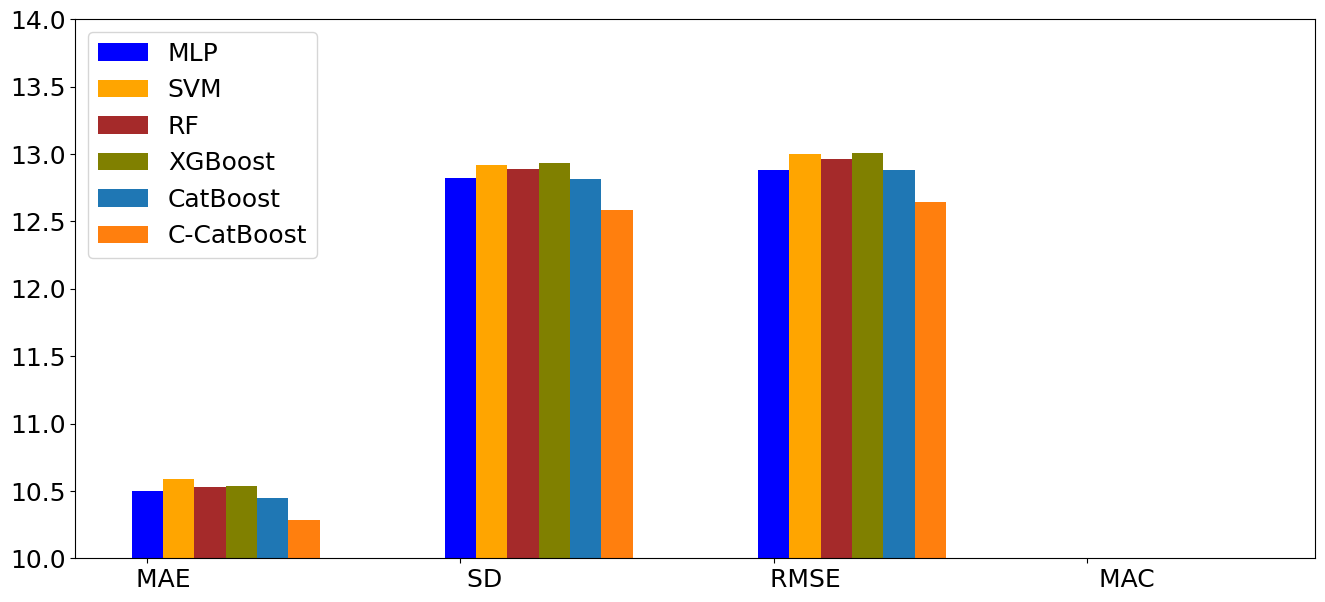

In [34]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt


mlp = np.mean(mlps, axis=0)
svm = np.mean(svms, axis=0)
rf = np.mean(rfs, axis=0)
xgb = np.mean(xgbs, axis=0)
cat = np.mean(cats, axis=0)
ccat = np.mean(ccats, axis=0)
names = ['    MAE', '      SD','        RMSE','          MAC']

figure(num=None, figsize=(16, 7))
y_pos=np.arange(len(names))
plt.bar(y_pos + 0, mlp,width=0.1, color = 'blue' , label='MLP')
plt.bar(y_pos + 0.1, svm,width=0.1, color = 'orange' , label='SVM')
plt.bar(y_pos + 0.2, rf,width=0.1, color = 'brown' , label='RF')
plt.bar(y_pos + 0.3, xgb,width=0.1, color = 'olive' , label='XGBoost')
plt.bar(y_pos + 0.4, cat,width=0.1, label='CatBoost')
plt.bar(y_pos + 0.5, ccat,width=0.1, label='C-CatBoost')

font = {
#     'family' : 'Times New Roman',
#         'weight' : 'bold',
        'size'   : 18}
plt.rcParams.update({'font.size': 18})
plt.rc('font', **font)
plt.ylim(10, 14)
plt.xticks(y_pos, names)
plt.legend(('MLP', 'SVM','RF','XGBoost','CatBoost','C-CatBoost'),loc='upper left')
plt.savefig('mathCase3.eps', format='eps',bbox_inches='tight')
# plt.title("Put a title here")
plt.show()

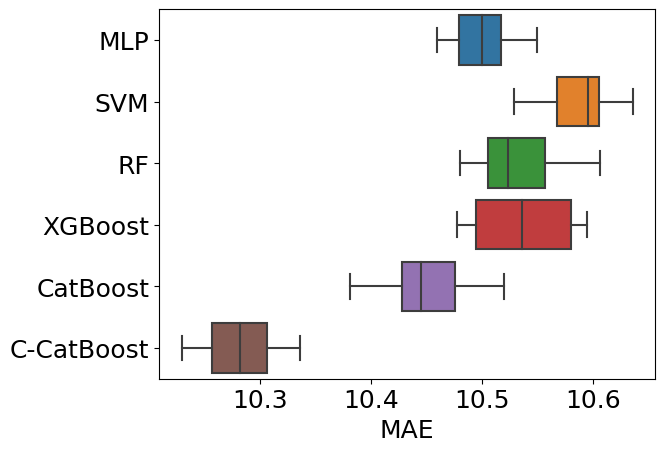

In [31]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 0
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="MAE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('mathMAECase3.eps', format='eps',bbox_inches  ='tight')

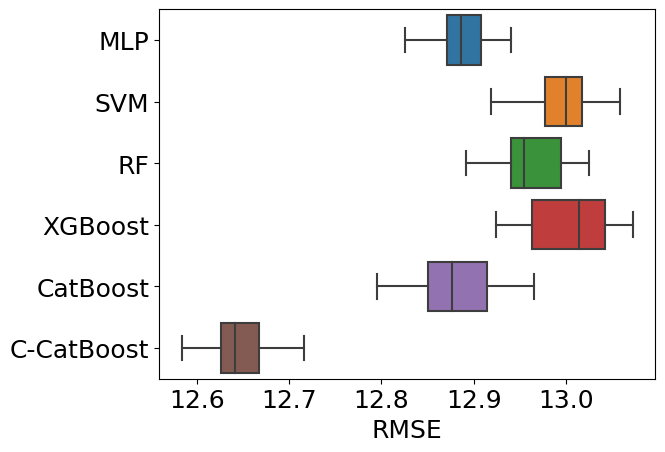

In [32]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 2
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="RMSE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('mathRMSECase3.eps', format='eps',bbox_inches  ='tight')

In [33]:
# for i in range(4):
#     print(ranksums(mlp[:,i], svm[:,i]).pvalue)
# i=0
for i in range(4):
    print(ranksums(ccats[:,i], mlps[:,i]).pvalue)
    print(ranksums(ccats[:,i], svms[:,i]).pvalue)
    print(ranksums(ccats[:,i], rfs[:,i]).pvalue)
    print(ranksums(ccats[:,i], xgbs[:,i]).pvalue)
    print(ranksums(ccats[:,i], cats[:,i]).pvalue)
    print()


6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

